In [16]:
import warnings
warnings.filterwarnings("ignore")  # "error", "ignore", "always", "default", "module" or "once"

In [17]:
import numpy as np
import pandas as pd
import random
import os
#from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import  keras
# from tensorflow.keras import backend as K

from federated_utils_fedavg import *

In [19]:
#declear path to your data
drebin_data_path = r'H:\GIT project\DW-FedAvg\data\drebin.csv'
malgenome_data_path = r'H:\GIT project\DW-FedAvg\data\malgenome.csv'
kronodroid_data_path = r'H:\GIT project\DW-FedAvg\data\kronodroid.csv'
TUANDROMD_data_path=r'H:\GIT project\DW-FedAvg\data\TUANDROMD.csv'



Drebin_data = pd.read_csv(drebin_data_path, header = None)

Malgenome_data = pd.read_csv(malgenome_data_path)

Tuandromd_data=pd.read_csv(TUANDROMD_data_path)

kronodroid_data=pd.read_csv(kronodroid_data_path)
Kronodroid_data = kronodroid_data.iloc[:,range(1,kronodroid_data.shape[1])]

In [20]:
lambda_ = 0.1  # Adjust the value based on your requirements  for Fedprox
tf.config.run_functions_eagerly(True)

def proximal_loss(global_weights, local_weights, lambda_):
    squared_diff = [tf.reduce_sum(tf.square(w - v)) for w, v in zip(local_weights, global_weights)]
    proximal_term = 0.5* lambda_ * tf.reduce_sum(squared_diff)
    return proximal_term

def custom_loss(y_true, y_pred):
    # Calculate the local loss (binary_crossentropy)
    local_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)

    # Calculate the proximal term
    proximal_term = proximal_loss(global_weights, local_model.get_weights(), lambda_)

    # Combine local loss and proximal term
    total_loss = local_loss + proximal_term

    return total_loss
all_avg =[]

all_std =[]

n_clients = [5,10,15]
n_round = [10,20]





dataset = ['Drebin', 'Malgenome', 'Kronodroid', 'Tuandromd' ]


# for d in range(0,1):
for d in range(0,2):
    if d == 0:
        use_data = Drebin_data
    elif d==1:
        use_data = Malgenome_data
    elif d==2:
        use_data = Kronodroid_data
    elif d==3:
        use_data = Tuandromd_data
        
        
    print('===================================================================================================')
    print('Working with:',dataset[d])
    print('===================================================================================================')

    for r in n_round: #number of rounds loop
        comms_round = r
        for cl in n_clients: #number of clients loop
            number_of_clients = cl

            # from sklearn.utils import shuffle
            # use_data = shuffle(use_data)
            # use_data
            print('---------------------------------------------')
            print('No. of Clients:', number_of_clients)
            print('No. of Rounds:', comms_round)
            print('---------------------------------------------')


            features = np.array(use_data.iloc[:,range(0,use_data.shape[1]-1)]) #feature set

            labels = use_data.iloc[:,-1] #labels --> B : Benign and S


            #Do feature scaling 


            X = preprocessing.StandardScaler().fit(features).transform(features)


            #binarize the labels
            lb = LabelBinarizer()
            y = lb.fit_transform(labels)


            #split data into training and test set
            X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                y, shuffle=True,
                                                                test_size=0.2, 
                                                                random_state=100)



            #create clients -- Horizontal FL
            clients = create_clients(X_train, y_train, num_clients=number_of_clients, initial='client')

            #process and batch the training data for each client
            clients_batched = dict()
            for (client_name, data) in clients.items():
                clients_batched[client_name] = batch_data(data)


                #process and batch the test set  
            test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

            #==============================================
            # Traditional FedProx 2017
            #==============================================
            #-----------------------------------------------


            all_results=list()

            #create optimizer
            lr = 0.01 
            loss='binary_crossentropy'
            metrics = ['accuracy']
            optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr, 
                            decay=lr / comms_round, 
                            momentum=0.9
                           )

            #initialize global model
            smlp_global = SimpleMLP()
            global_model = smlp_global.build(X.shape[1],1)
            #-----------------------------------------------


            print('|=======================|')
            print('|Traditional FedProx 2017|')
            print('|=======================|')

            #commence global training loop
            for comm_round in range(comms_round):

                # get the global model's weights - will serve as the initial weights for all local models
                global_weights = global_model.get_weights()

                #initial list to collect local model weights after scalling
                scaled_local_weight_list = list()

                #randomize client data - using keys
                client_names= list(clients_batched.keys())
                random.shuffle(client_names)

                #loop through each client and create new local model
                for client in client_names:
                    smlp_local = SimpleMLP()
                    local_model = smlp_local.build(X.shape[1],1)
                    local_model.compile(loss=custom_loss, 
                                  optimizer=optimizer, 
                                  metrics=metrics)

                    #set local model weight to the weight of the global model
                    local_model.set_weights(global_weights)

                    #fit local model with client's data
                    local_model.fit(clients_batched[client], epochs=32, verbose=0)

                    #scale the model weights and add to list
                    scaling_factor = weight_scalling_factor(clients_batched, client)
                    scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
                    scaled_local_weight_list.append(scaled_weights)

                    #clear session to free memory after each communication round
                    keras.backend.clear_session()

                #to get the average over all the local model, we simply take the sum of the scaled weights
                average_weights = sum_scaled_weights(scaled_local_weight_list)

                #update global model 
                global_model.set_weights(average_weights)

                #test global model and print out metrics after each communications round
                for(X_test, Y_test) in test_batched:
                    global_acc, global_loss, global_f1, global_precision, global_recall, global_auc, global_fpr = test_model(X_test, Y_test, global_model, comm_round)
                    all_results.append([global_acc,global_loss.numpy(),global_f1, global_precision, global_recall, global_auc, global_fpr])


            all_R = pd.DataFrame(all_results, columns=['global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
            flname = 'results/round-'+str(r)+'/'+str(cl)+'-clients/FedProx-'+dataset[d]+'-results.csv'
            all_R.to_csv(flname, index=None)
            
            
            all_avg.append(np.concatenate(([dataset[d],r,cl],np.mean(all_results,axis=0)))) #Storing avg values for each dataset
            all_std.append(np.concatenate(([dataset[d],r,cl],np.std(all_results,axis=0)))) #Storing std values sfor each dataset
          

            
ALL_AVG = pd.DataFrame(all_avg, columns = ['Dataset', 'num of round', 'num of cliends','global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
ALL_AVG.to_csv(f'FedProx-results.csv')     

ALL_STD = pd.DataFrame(all_std, columns = ['Dataset', 'num of round', 'num of cliends','global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
ALL_STD.to_csv('FedProx-all-std-results.csv')

Working with: Drebin
---------------------------------------------
No. of Clients: 5
No. of Rounds: 10
---------------------------------------------
|=======================|
|Traditional FedProx 2017|
|=======================|
94/94 [==============================] - 1s 10ms/step
comm_round: 0 | global_acc: 97.839% | global_loss: 0.5653417706489563 | global_f1: 0.9704142011834319 | global_precision: 0.9797794117647058 | global_recall: 0.9612263300270514 | global_auc: 0.9951364939356341| flobal_FPR: 0.0387736699729486 
94/94 [==============================] - 1s 8ms/step
comm_round: 1 | global_acc: 98.138% | global_loss: 0.5644866228103638 | global_f1: 0.9746376811594203 | global_precision: 0.9790718835304822 | global_recall: 0.9702434625788999 | global_auc: 0.9954828866790028| flobal_FPR: 0.029756537421100092 


KeyboardInterrupt: 

In [ ]:
print((all_avg[0]))

['Drebin' '10' '5' '0.9822805851063829' '0.5641639709472657'
 '0.9758701733506149' '0.9798174987444629' '0.9719567177637511'
 '0.9949485064276151' '0.028043282236248874']


In [ ]:

all_avg =[]

all_std =[]

n_clients = [5,10,15]
n_round = [10,20]


dataset = ['Drebin', 'Malgenome', 'Kronodroid', 'Tuandromd' ]


for d in range(0,1):
    if d == 0:
        use_data = Drebin_data
    elif d==1:
        use_data = Malgenome_data
    elif d==2:
        use_data = Kronodroid_data
    elif d==3:
        use_data = Tuandromd_data
        
        
    print('===================================================================================================')
    print('Working with:',dataset[d])
    print('===================================================================================================')

    for r in n_round: #number of rounds loop
        comms_round = r
        for cl in n_clients: #number of clients loop
            number_of_clients = cl

            # from sklearn.utils import shuffle
            # use_data = shuffle(use_data)
            # use_data
            print('---------------------------------------------')
            print('No. of Clients:', number_of_clients)
            print('No. of Rounds:', comms_round)
            print('---------------------------------------------')


            features = np.array(use_data.iloc[:,range(0,use_data.shape[1]-1)]) #feature set

            labels = use_data.iloc[:,-1] #labels --> B : Benign and S


            #Do feature scaling 


            X = preprocessing.StandardScaler().fit(features).transform(features)


            #binarize the labels
            lb = LabelBinarizer()
            y = lb.fit_transform(labels)


            #split data into training and test set
            X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                y, shuffle=True,
                                                                test_size=0.2, 
                                                                random_state=100)



            #create clients -- Horizontal FL
            clients = create_clients(X_train, y_train, num_clients=number_of_clients, initial='client')

            #process and batch the training data for each client
            clients_batched = dict()
            for (client_name, data) in clients.items():
                clients_batched[client_name] = batch_data(data)


                #process and batch the test set  
            test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

            #==============================================
            # Traditional FedProx 2017
            #==============================================
            #-----------------------------------------------


            all_results=list()

            #create optimizer
            lr = 0.01 
            loss='binary_crossentropy'
            metrics = ['accuracy']
            optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr, 
                            decay=lr / comms_round, 
                            momentum=0.9
                           )

            #initialize global model
            smlp_global = SimpleMLP()
            global_model = smlp_global.build(X.shape[1],1)
            #-----------------------------------------------


            print('|=======================|')
            print('|Traditional FedProx 2017|')
            print('|=======================|')

            #commence global training loop
            for comm_round in range(comms_round):

                # get the global model's weights - will serve as the initial weights for all local models
                global_weights = global_model.get_weights()

                #initial list to collect local model weights after scalling
                scaled_local_weight_list = list()

                #randomize client data - using keys
                client_names= list(clients_batched.keys())
                random.shuffle(client_names)

                #loop through each client and create new local model
                for client in client_names:
                    smlp_local = SimpleMLP()
                    local_model = smlp_local.build(X.shape[1],1)
                    local_model.compile(loss=loss, 
                                  optimizer=optimizer, 
                                  metrics=metrics)

                    #set local model weight to the weight of the global model
                    local_model.set_weights(global_weights)

                    #fit local model with client's data
                    local_model.fit(clients_batched[client], epochs=32, verbose=0)

                    #scale the model weights and add to list
                    scaling_factor = weight_scalling_factor(clients_batched, client)
                    scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
                    scaled_local_weight_list.append(scaled_weights)

                    #clear session to free memory after each communication round
                    keras.backend.clear_session()

                #to get the average over all the local model, we simply take the sum of the scaled weights
                average_weights = sum_scaled_weights(scaled_local_weight_list)

                #update global model 
                global_model.set_weights(average_weights)

                #test global model and print out metrics after each communications round
                for(X_test, Y_test) in test_batched:
                    global_acc, global_loss, global_f1, global_precision, global_recall, global_auc, global_fpr = test_model(X_test, Y_test, global_model, comm_round)
                    all_results.append([global_acc,global_loss.numpy(),global_f1, global_precision, global_recall, global_auc, global_fpr])



            all_R = pd.DataFrame(all_results, columns=['global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
            flname = 'results/round-'+str(r)+'/'+str(cl)+'-clients/FedProx-'+dataset[d]+'-results.csv'
            all_R.to_csv(flname, index=None)
            
            
            all_avg.append(np.concatenate(([dataset[d],r,cl],np.mean(all_results,axis=0)))) #Storing avg values for each dataset
            all_std.append(np.concatenate(([dataset[d],r,cl],np.std(all_results,axis=0)))) #Storing std values sfor each dataset
            

            

            
ALL_AVG = pd.DataFrame(all_avg, columns = ['Dataset', 'num of round', 'num of cliends','global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
ALL_AVG.to_csv(f'FedProx-results.csv')     

ALL_STD = pd.DataFrame(all_std, columns = ['Dataset', 'num of round', 'num of cliends','global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
ALL_STD.to_csv('FedProx-all-std-results.csv')

Working with: Drebin
---------------------------------------------
No. of Clients: 5
No. of Rounds: 10
---------------------------------------------
|=======================|
|Traditional FedAvg 2017|
|=======================|


KeyboardInterrupt: 

In [ ]:
ALL_AVG = pd.DataFrame(all_avg, columns = ['Dataset','Rounds','no-clients','global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
ALL_AVG.to_csv('FedProx-all-avg-results.csv')

ALL_STD = pd.DataFrame(all_std, columns = ['Dataset','Rounds','no-clients','global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
ALL_STD.to_csv('FedProx-all-std-results.csv')

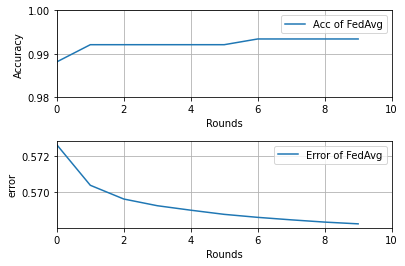

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

s1 = np.array(all_results) #FedProx

t = range(0,s1.shape[0])

ax1.plot(t, s1[:,0],label='Acc of FedProx')
ax1.set_xlim(0,s1.shape[0])
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.98,1)
ax1.grid(True)
ax1.legend()


ax2.plot(t, s1[:,1],label='Error of FedProx')
ax2.set_xlim(0, s1.shape[0])
ax2.set_xlabel('Rounds')
ax2.set_ylabel('error')
ax2.grid(True)
ax2.legend()

plt.show()



In [ ]:
s1.shape

(10, 2)